In [14]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
%load_ext ipycache
%precision 4
from ipy_table import make_table, apply_theme
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import networkxgmml

from sklearn import linear_model

sb.set_context('poster')
sb.set_style('white')
sb.set_color_codes()

seeds_file = "c_all.txt"
with open(seeds_file) as sf:
    genes = [line.strip() for line in sf.readlines()]

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


In [3]:
import networkx as nx
net_file = "HINT_adjlist.txt"
G1 = nx.read_adjlist(net_file)
G1.remove_edges_from(G1.selfloop_edges())
## Find largest connected component
CC=sorted(nx.connected_components(G1), key = len, reverse=True)[0]
G1=G1.subgraph(CC)

In [8]:
import mygene
import itertools
mg = mygene.MyGeneInfo()
mygene_hits1 = mg.querymany([i for i in set(itertools.chain(genes, G1.nodes()))],
                           scopes="entrezgene", fields="symbol,alias")
from collections import defaultdict
symbols1 = defaultdict(list)
symbol_to_ez1 = {}
for h in mygene_hits1:
    ez = h['query']
    if h.get('notfound', False):
        symbols1[ ez ].append(ez)
        continue
    symbols1[ ez ].append(h.get('symbol', ez).upper())
    for a in h.get('alias', []):
        symbols1[ ez ].append(a.upper())
    for s in symbols1[ ez]:
        symbol_to_ez1[s] = ez

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-10662...done.
Finished.
29 input query terms found no hit:
	[u'378465', u'9503', u'6775098', u'90462', u'100271840', u'244', u'221016', u'102723367', u'439935',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [12]:
def ppr(g, beta, nodelist=None):
    W = nx.to_numpy_matrix(g, nodelist=nodelist, dtype=np.float64 )
    W = np.asarray(W)
    W = W / W.sum(axis=1) # normalization step
    from scipy.linalg import inv
    n = len(g.nodes())
    PPR = beta*inv(sp.eye(n)-(1.-beta)*W)
    return PPR

In [13]:
beta = 0.4
G1_index2ezgene = dict((i,n) for i,n in enumerate(G1.nodes()))
G1_ezgene2index = dict((n,i) for i,n in G1_index2ezgene.items())
G1_gene_names = [symbols1[ez][0] for ez in G1.nodes()]
G1_index2gene = dict((i,symbols1[ez][0]) for i,ez in G1_index2ezgene.items())
G1_gene2index = dict((n,i) for i,n in G1_index2gene.items())
M1 = ppr(G1, beta)

In [15]:
def get_seeds_with_neighbors1(dataset):
    return {g: dict((G1_index2ezgene[i], n)
                                 for i, n in enumerate(M1[:,G1_ezgene2index[g]].tolist())
                                if G1_index2ezgene[i] in dataset.columns
                               )
                            for g in genes if g in dataset.columns and g in G1_ezgene2index}

In [250]:
gse45965 = pd.read_csv("gse45965_centered.csv", index_col="sample")

In [251]:
gse45965_ctc_vs_bc = gse45965[(gse45965.group == 'CTC') | (gse45965.group == 'tissue: breast cancer tumor')]
gse45965_ctc_vs_pb = gse45965[(gse45965.group == 'CTC') | (gse45965.group == 'tissue: normal peripheral blood')]
gse45965_pb_vs_bc = gse45965[(gse45965.group == 'tissue: breast cancer tumor') | (gse45965.group == 'tissue: normal peripheral blood')]
gse45965_ctc_vs_bc_group = np.where(gse45965_ctc_vs_bc.group == 'CTC', 1, 0)
gse45965_ctc_vs_pb_group = np.where(gse45965_ctc_vs_pb.group == 'CTC', 1, 0)
gse45965_pb_vs_bc_group = np.where(gse45965_pb_vs_bc.group == 'tissue: breast cancer tumor', 1, 0)

#### CTC versus Breast Cancer

In [252]:
%run subnet_stacking.py
from sklearn.pipeline import Pipeline
g27_clf = Pipeline([('subset_g27', GeneSubsetTransformer(features=[g for g in genes if g in gse45965.columns])),
                   ('logreg', linear_model.LogisticRegression())])
clfs = [linear_model.LogisticRegression(), g27_clf, 
        SubnetStackingClassifier(seeds_with_neighbors=get_seeds_with_neighbors1(gse45965_ctc_vs_pb.drop("group",1)))]
scores_ctc_vs_pb, fitted_clfs_ctc_vs_pb = score_clfs_in_df(clfs, gse45965_ctc_vs_pb.drop("group",1), 
                                                         gse45965_ctc_vs_pb_group,
                                                         n_iter = 10)

* 1 / 10
* 2 / 10
* 3 / 10
* 4 / 10
* 5 / 10
* 6 / 10
* 7 / 10
* 8 / 10
* 9 / 10
* 10 / 10


In [253]:
np.mean(np.stack(s["roc_auc"] for s in scores_ctc_vs_pb), axis=0)

array([ 0.95 ,  0.925,  0.925])

#### CTC versus peripheral blood

In [254]:
scores_ctc_vs_pb, fitted_clfs_ctc_vs_pb = score_clfs_in_df(clfs,
                                                         gse45965_ctc_vs_pb.drop("group",1), 
                                                        gse45965_ctc_vs_pb_group,
                                                        n_iter = 100, verbose=True)

* 1 / 100
* 2 / 100
* 3 / 100
* 4 / 100
* 5 / 100
* 6 / 100
* 7 / 100
* 8 / 100
* 9 / 100
* 10 / 100
* 11 / 100
* 12 / 100
* 13 / 100
* 14 / 100
* 15 / 100
* 16 / 100
* 17 / 100
* 18 / 100
* 19 / 100
* 20 / 100
* 21 / 100
* 22 / 100
* 23 / 100
* 24 / 100
* 25 / 100
* 26 / 100
* 27 / 100
* 28 / 100
* 29 / 100
* 30 / 100
* 31 / 100
* 32 / 100
* 33 / 100
* 34 / 100
* 35 / 100
* 36 / 100
* 37 / 100
* 38 / 100
* 39 / 100
* 40 / 100
* 41 / 100
* 42 / 100
* 43 / 100
* 44 / 100
* 45 / 100
* 46 / 100
* 47 / 100
* 48 / 100
* 49 / 100
* 50 / 100
* 51 / 100
* 52 / 100
* 53 / 100
* 54 / 100
* 55 / 100
* 56 / 100
* 57 / 100
* 58 / 100
* 59 / 100
* 60 / 100
* 61 / 100
* 62 / 100
* 63 / 100
* 64 / 100
* 65 / 100
* 66 / 100
* 67 / 100
* 68 / 100
* 69 / 100
* 70 / 100
* 71 / 100
* 72 / 100
* 73 / 100
* 74 / 100
* 75 / 100
* 76 / 100
* 77 / 100
* 78 / 100
* 79 / 100
* 80 / 100
* 81 / 100
* 82 / 100
* 83 / 100
* 84 / 100
* 85 / 100
* 86 / 100
* 87 / 100
* 88 / 100
* 89 / 100
* 90 / 100
* 91 / 100
* 92 / 1

In [255]:
pd.DataFrame({"Classifier": [str_clf(c) for c in clfs],
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in scores_ctc_vs_pb), axis=0)})

,Classifier,ROC AUC
0,LogisticRegression,0.9700
1,Pipeline,0.9625
2,SubnetStackingClassifier,0.9375


#### Peripheral Blood versus Breast Cancer

In [256]:
scores_pb_vs_bc, fitted_clfs_pb_vs_bc = score_clfs_in_df(clfs,
                                                         gse45965_pb_vs_bc.drop("group",1), 
                                                        gse45965_pb_vs_bc_group,
                                                        n_iter = 100, verbose=True)

* 1 / 100
* 2 / 100
* 3 / 100
* 4 / 100
* 5 / 100
* 6 / 100
* 7 / 100
* 8 / 100
* 9 / 100
* 10 / 100
* 11 / 100
* 12 / 100
* 13 / 100
* 14 / 100
* 15 / 100
* 16 / 100
* 17 / 100
* 18 / 100
* 19 / 100
* 20 / 100
* 21 / 100
* 22 / 100
* 23 / 100
* 24 / 100
* 25 / 100
* 26 / 100
* 27 / 100
* 28 / 100
* 29 / 100
* 30 / 100
* 31 / 100
* 32 / 100
* 33 / 100
* 34 / 100
* 35 / 100
* 36 / 100
* 37 / 100
* 38 / 100
* 39 / 100
* 40 / 100
* 41 / 100
* 42 / 100
* 43 / 100
* 44 / 100
* 45 / 100
* 46 / 100
* 47 / 100
* 48 / 100
* 49 / 100
* 50 / 100
* 51 / 100
* 52 / 100
* 53 / 100
* 54 / 100
* 55 / 100
* 56 / 100
* 57 / 100
* 58 / 100
* 59 / 100
* 60 / 100
* 61 / 100
* 62 / 100
* 63 / 100
* 64 / 100
* 65 / 100
* 66 / 100
* 67 / 100
* 68 / 100
* 69 / 100
* 70 / 100
* 71 / 100
* 72 / 100
* 73 / 100
* 74 / 100
* 75 / 100
* 76 / 100
* 77 / 100
* 78 / 100
* 79 / 100
* 80 / 100
* 81 / 100
* 82 / 100
* 83 / 100
* 84 / 100
* 85 / 100
* 86 / 100
* 87 / 100
* 88 / 100
* 89 / 100
* 90 / 100
* 91 / 100
* 92 / 1

In [257]:
pd.DataFrame({"Classifier": [str_clf(c) for c in clfs],
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in scores_pb_vs_bc), axis=0)})

,Classifier,ROC AUC
0,LogisticRegression,0.701250
1,Pipeline,0.949375
2,SubnetStackingClassifier,0.873750


In [258]:
np.std(np.stack(s["roc_auc"] for s in scores_pb_vs_bc), axis=0)

array([ 0.0618,  0.0981,  0.1452])

In [259]:
from sklearn import svm
from sklearn import linear_model
from sklearn import tree
from sklearn import neighbors
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.ensemble import RandomForestClassifier

scores_1, _ = score_clfs_in_df([linear_model.LogisticRegression(), neighbors.KNeighborsClassifier(n_neighbors=5), 
                               RandomForestClassifier(), svm.SVC(kernel="rbf", C=1), svm.SVC(kernel="linear", C=1)],
                                                         gse45965_ctc_vs_pb.drop("group",1), 
                                                        gse45965_ctc_vs_pb_group,
                                                        n_iter = 100)

* 1 / 100
* 2 / 100
* 3 / 100
* 4 / 100
* 5 / 100
* 6 / 100
* 7 / 100
* 8 / 100
* 9 / 100
* 10 / 100
* 11 / 100
* 12 / 100
* 13 / 100
* 14 / 100
* 15 / 100
* 16 / 100
* 17 / 100
* 18 / 100
* 19 / 100
* 20 / 100
* 21 / 100
* 22 / 100
* 23 / 100
* 24 / 100
* 25 / 100
* 26 / 100
* 27 / 100
* 28 / 100
* 29 / 100
* 30 / 100
* 31 / 100
* 32 / 100
* 33 / 100
* 34 / 100
* 35 / 100
* 36 / 100
* 37 / 100
* 38 / 100
* 39 / 100
* 40 / 100
* 41 / 100
* 42 / 100
* 43 / 100
* 44 / 100
* 45 / 100
* 46 / 100
* 47 / 100
* 48 / 100
* 49 / 100
* 50 / 100
* 51 / 100
* 52 / 100
* 53 / 100
* 54 / 100
* 55 / 100
* 56 / 100
* 57 / 100
* 58 / 100
* 59 / 100
* 60 / 100
* 61 / 100
* 62 / 100
* 63 / 100
* 64 / 100
* 65 / 100
* 66 / 100
* 67 / 100
* 68 / 100
* 69 / 100
* 70 / 100
* 71 / 100
* 72 / 100
* 73 / 100
* 74 / 100
* 75 / 100
* 76 / 100
* 77 / 100
* 78 / 100
* 79 / 100
* 80 / 100
* 81 / 100
* 82 / 100
* 83 / 100
* 84 / 100
* 85 / 100
* 86 / 100
* 87 / 100
* 88 / 100
* 89 / 100
* 90 / 100
* 91 / 100
* 92 / 1

In [260]:
pd.DataFrame({"Classifier": [str_clf(c) for c in more_clfs], 
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in scores_1), axis=0)})

,Classifier,ROC AUC
0,LogisticRegression,0.9700
1,KNeighborsClassifier,0.8975
2,RandomForestClassifier,0.8475
3,SVC,0.9350
4,SVC,0.9900


In [261]:
more_clfs = [linear_model.LogisticRegression(), 
                                neighbors.KNeighborsClassifier(n_neighbors=5), 
                                RandomForestClassifier(), 
                                svm.SVC(kernel="rbf", C=1), 
                                svm.SVC(kernel="linear", C=1)]
scores_2, _ = score_clfs_in_df(more_clfs,
                               gse45965_pb_vs_bc.drop("group",1), 
                                                        gse45965_pb_vs_bc_group,
                                                        n_iter = 100, verbose=False)

In [262]:
pd.DataFrame({"Classifier": [str_clf(c) for c in more_clfs], 
              "ROC AUC": np.mean(np.stack(s["roc_auc"] for s in scores_2), axis=0)})

,Classifier,ROC AUC
0,LogisticRegression,0.701250
1,KNeighborsClassifier,0.859062
2,RandomForestClassifier,0.841875
3,SVC,0.822500
4,SVC,0.953438


In [263]:
all_clfs = [linear_model.LogisticRegression(), 
                                neighbors.KNeighborsClassifier(n_neighbors=5), 
                                RandomForestClassifier(), 
                                svm.SVC(kernel="rbf", C=1), 
                                svm.SVC(kernel="linear", C=1),
             g27_clf, 
            SubnetStackingClassifier(seeds_with_neighbors=get_seeds_with_neighbors1(gse45965_ctc_vs_pb.drop("group",1)))
            ]

In [ ]:
import sklearn.cross_validation
random_state = np.random.RandomState(0xBABE)
cvs = [cross_validation.StratifiedKFold(gse45965_pb_vs_bc_group, n_folds=3, random_state=random_state)
       for _ in range(500)]

In [ ]:
pps = []
for cv in cvs:
    p = [(c, sklearn.cross_validation.cross_val_score(c,
                                         gse45965_pb_vs_bc.drop("group", 1),
                                         gse45965_pb_vs_bc_group, cv=cv, scoring="roc_auc"))
         for c in all_clfs]
    pps.append( p)

In [ ]:

pd.DataFrame({"AUC": [v*1.0/len(pps) for c,v in st.iteritems()]}, index=[str_clf(c) for c in st.keys()])

## Repeated CV
We are going to test the Subnet Stackign classisifier with repeated cross validation (See: Ji-Hyun Kim, "Estimating classification error rate: Repeated cross-validation, repeated hold-out and bootstrap, Computational Statistics & Data Analysis, Vol 53(11), http://dx.doi.org/10.1016/j.csda.2009.04.009))


In [279]:
all_clfs = {"Logistic Regression": linear_model.LogisticRegression(), 
            "K-nearest Neighbors(k=5)": neighbors.KNeighborsClassifier(n_neighbors=5), 
            "Random Forrest": RandomForestClassifier(), 
            "SVM-RBF": svm.SVC(kernel="rbf", C=1), 
             "SVM-Linear": svm.SVC(kernel="linear", C=1),
             "Log. regression (G27)": g27_clf, 
            "Subnet Stacking": SubnetStackingClassifier(seeds_with_neighbors=get_seeds_with_neighbors1(gse45965.drop("group",1)))
            }
n_iter = 100
n_jobs = 20

We are going to use 100 iterations in parallel (20 processes) of 3-fold cross validation, which means 300 training and testing sets..

#### CTC versus Peripheral Blood

In [280]:
from sklearn import cross_validation
random_state = np.random.RandomState(0xCAFE)
cvs_ctc_vs_pb = [cross_validation.StratifiedKFold(gse45965_ctc_vs_pb_group, n_folds=3, 
                                                  shuffle=True, random_state=random_state)
                 for _ in range(n_iter)]

How many distinct testing sets we have?

In [281]:
from collections import defaultdict
st=defaultdict(int)
def str_set(s): return ":".join(str(k) for k in s)
for cv in cvs_ctc_vs_pb:
    for train,test in cv:
        st[ str_set(set(test)) ] += 1
print len(st.keys())


232


In [282]:
def parallel_cv(cv, all_clfs, X, y):
    import sklearn.cross_validation
    p = {n : sklearn.cross_validation.cross_val_score(c, X,y, cv=cv, scoring="roc_auc")
         for n, c in all_clfs.items()}
    return p

Start the Cross Validations.. This takes a lot of time!!

In [283]:
from joblib import Parallel, delayed
scores_ctc_vs_pb = Parallel(n_jobs=n_jobs)(delayed(parallel_cv)(cv, all_clfs, 
                                                gse45965_ctc_vs_pb.drop("group",1), 
                                                gse45965_ctc_vs_pb_group)
                           for cv in cvs_ctc_vs_pb)

In [284]:
from collections import defaultdict
st=defaultdict(int)
for pp in scores_ctc_vs_pb:
    for n, s in pp.items():
        st[n] += np.mean(s)
pd.DataFrame({"AUC": [v*1.0/n_iter for c,v in st.iteritems()],
              "std. dev": [np.std(v) for c,v in st.iteritems()]},
             index=[c for c,v in st.iteritems()])


,AUC,std. dev
SVM-Linear,1.000000,0
Logistic Regression,1.000000,0
Log. regression (G27),1.000000,0
Random Forrest,0.961944,0
SVM-RBF,1.000000,0
Subnet Stacking,1.000000,0
K-nearest Neighbors(k=5),0.985278,0


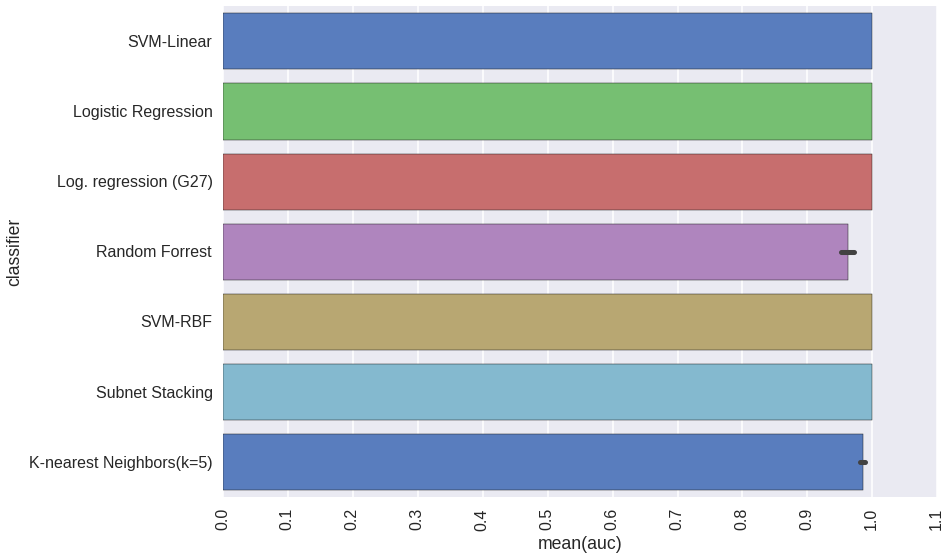

In [285]:
st=[]
for pp in scores_ctc_vs_pb:
    for n, s in pp.items():
        st.append( (n, np.mean(s)) )
a = pd.DataFrame({'classifier': [v[0] for v in st], 'auc': [v[1] for v in st]})
sb.set_style("darkgrid")
sb.barplot(y="classifier", x="auc", data=a, palette="muted")
plt.xticks(np.arange(0,1.12,0.1), rotation=90)
plt.show()

#### Peripheral Blood vs Breast Cancer

In [286]:
random_state = np.random.RandomState(0xCAFE)
cvs_pb_vs_bc = [cross_validation.StratifiedKFold(gse45965_pb_vs_bc_group, n_folds=3, 
                                                  shuffle=True, random_state=random_state)
                 for _ in range(n_iter)]

How many distinct testing sets we have?

In [ ]:
from collections import defaultdict
st=defaultdict(int)
def str_set(s): return ":".join(str(k) for k in s)
for cv in cvs_pb_vs_bc:
    for train,test in cv:
        st[ str_set(set(test)) ] += 1
print len(st.keys())

300


In [ ]:
from joblib import Parallel, delayed
scores_pb_vs_bc = Parallel(n_jobs=n_jobs, verbose=5)(delayed(parallel_cv)(cv, all_clfs, 
                                                gse45965_pb_vs_bc.drop("group",1), 
                                                gse45965_pb_vs_bc_group)
                           for cv in cvs_pb_vs_bc)


In [ ]:
from collections import defaultdict
st=defaultdict(list)
for pp in scores_pb_vs_bc:
    for n, s in pp.items():
        st[n].append(np.mean(s))
pd.DataFrame({"Avg. AUC": [np.mean(v) for c,v in st.iteritems()],
              "std. dev": [np.std(v) for c,v in st.iteritems()]}
             , index=[c for c,v in st.iteritems()])


In [ ]:
st=[]
for pp in scores_pb_vs_bc:
    for n, s in pp.items():
        st.append( (n, np.mean(s)) )
a = pd.DataFrame({'classifier': [v[0] for v in st], 'auc': [v[1] for v in st]})
sb.set_style("darkgrid")
sb.barplot(y="classifier", x="auc", data=a, palette="muted")
plt.xticks(np.arange(0,1.12,0.1), rotation=90)
plt.show()